In [81]:
# imports
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import IPython as ip
from IPython import display as display
import seaborn as sns
import sklearn as sk
import random
import time

# package versions and data input
print("--------------------------")
print("python:\t\t {}". format(sys.version))
print("pandas:\t\t {}". format(pd.__version__))
print("matplotlib:\t {}". format(mpl.__version__))
print("numpy:\t\t {}". format(np.__version__))
print("ipython:\t {}". format(ip.__version__))
print("seaborn:\t {}". format(sns.__version__))
print("sklearn:\t {}". format(sk.__version__))
print("--------------------------")
from subprocess import check_output
print(check_output(["ls", "../data"]).decode("utf8"))
print("--------------------------")

--------------------------
python:		 3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]
pandas:		 1.1.3
matplotlib:	 3.3.2
numpy:		 1.18.1
ipython:	 7.18.1
seaborn:	 0.11.0
sklearn:	 0.23.2
--------------------------
ks2016.csv
ks2018.csv
notebook.ipynb
titanic.csv

--------------------------


In [82]:
# import .csv file
data = pd.read_csv('ks2018.csv')

# number of samples
print('The number of samples the data set is {}.'.format(data.shape[0]))
print("--------------------------")

# null data
print('The data set has the following amount of null values')
print(data.isnull().sum())
print('Percentage missing for "name" %.4f%%' %((data['name'].isnull().sum()/data.shape[0])*100))
print('Percentage missing for "usd pledged" %.4f%%' %((data['usd pledged'].isnull().sum()/data.shape[0])*100))
print("--------------------------")

# possible outcomes
print('The following outcomes are possible')
print(data.state.unique())
print("--------------------------")

# possible categories
print('The following project categories exist')
print(data.main_category.unique())
print("--------------------------")

# possible currencies
print('The following currencies exist')
print(data.currency.unique())
print("--------------------------")

# possible countries
print('The following countries exist')
print(data.country.unique())
print("--------------------------")

# live projects
live = data.apply(lambda x: True if x['state'] == 'live' else False , axis=1)
liveAmount = len(live[live == True].index)
print('The amount of live projects is: ', liveAmount)
print('This is %.2f%% of the total projects' %((liveAmount/data.shape[0])*100))
print("--------------------------")


The number of samples the data set is 378661.
--------------------------
The data set has the following amount of null values
ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64
Percentage missing for "name" 0.0011%
Percentage missing for "usd pledged" 1.0027%
--------------------------
The following outcomes are possible
['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']
--------------------------
The following project categories exist
['Publishing' 'Film & Video' 'Music' 'Food' 'Design' 'Crafts' 'Games'
 'Comics' 'Fashion' 'Theater' 'Art' 'Photography' 'Technology' 'Dance'
 'Journalism']
--------------------------
The following currencies 

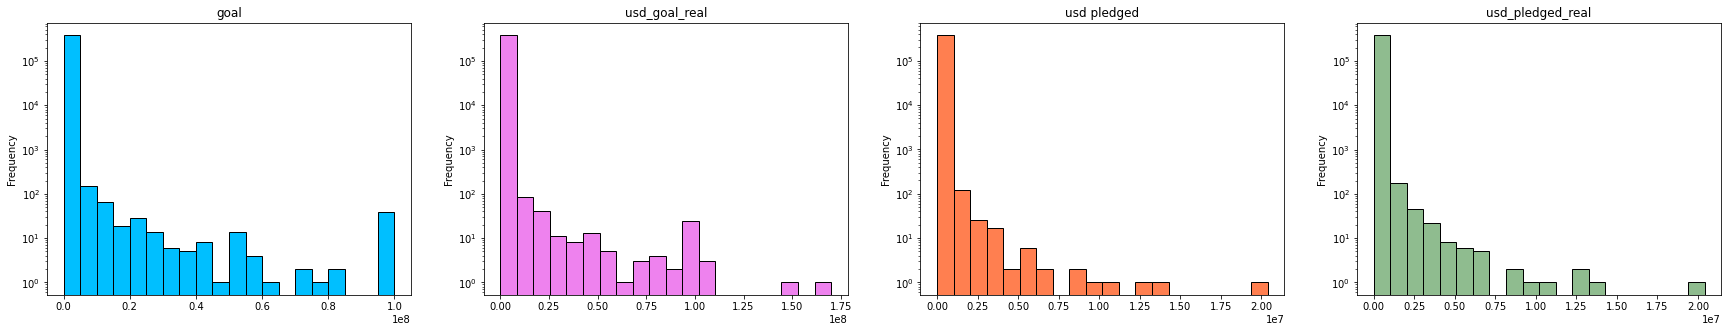

In [83]:
# find outliers
fig, axs = plt.subplots(ncols=4, figsize=(30,5))

# goal, kickstarter maximum is 100.000
axs[0].set_title("goal")
data['goal'].plot(kind='hist', bins=20, color='deepskyblue', edgecolor='black', log=True, range=[0,100000000], ax=axs[0])

# conversion based on historical forex rates
axs[1].set_title("usd_goal_real")
data['usd_goal_real'].plot(kind='hist', bins=20, color='violet', edgecolor='black', log=True, range=[0,170000000], ax=axs[1])

# pledged amount in USD, biggest being pebble watch
axs[2].set_title("usd pledged")
data['usd pledged'].plot(kind='hist', bins=20, color='coral', edgecolor='black', log=True, range=[0,20400000], ax=axs[2])

# pledged amount in USD, biggest being pebble watch
axs[3].set_title("usd_pledged_real")
data['usd_pledged_real'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[0,20400000], ax=axs[3])

plt.show()

In [87]:
# keep only certain columns and drop records with null values
# here we removed the rows/records that had null value for the project name
# note! make changes, run the cells above first, because otherwise we're working with a modified data set already
#data = data[['name', 'namelength', 'main_category','currency','deadline','goal','launched', 'country', 'state']].dropna()

# drop live projects
data.drop(data[data.state == 'live'].index, inplace=True)

# drop null names
data.drop(data[data.name.isnull()].index, inplace=True)

# check if we removed live projects
live = data.apply(lambda x: True if x['state'] == 'live' else False , axis=1)
liveAmount = len(live[live == True].index)
print('The amount of live projects is: ', liveAmount)
print('This is %.2f%% of the total projects' %((liveAmount/data.shape[0])*100))
print("--------------------------")

# check if we removed null names
print('The data set has the following amount of null values')
print(data.isnull().sum())
print("--------------------------") 

# create titlelength feature
data['titlelength'] = data['name'].str.len()

# create launchmonth feature
data['launchmonth'] = pd.DatetimeIndex(data['launched']).month

# create duration feature, days are rounded up
data['duration'] = (pd.to_datetime(data['deadline']) - pd.to_datetime(data['launched'])) / np.timedelta64(1, 'D')
data['duration'] = data['duration'].round(0).astype(int)

# convert variables to be numeric
#data.replace({'male': 1, 'female': 0}, inplace=True)


# replace data
#data.replace('?', np.nan, inplace= True)

# change data type
#data = data.astype({"usd_goal_real": np.float64})

The amount of live projects is:  0
This is 0.00% of the total projects
--------------------------
The data set has the following amount of null values
ID                     0
name                   0
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3796
usd_pledged_real       0
usd_goal_real          0
titlelength            0
launchmonth            0
duration               0
dtype: int64
--------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 375858 entries, 0 to 378660
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                375858 non-null  int64  
 1   name              375858 non-null  object 
 2   category          375858 non-null  object 
 3   mai

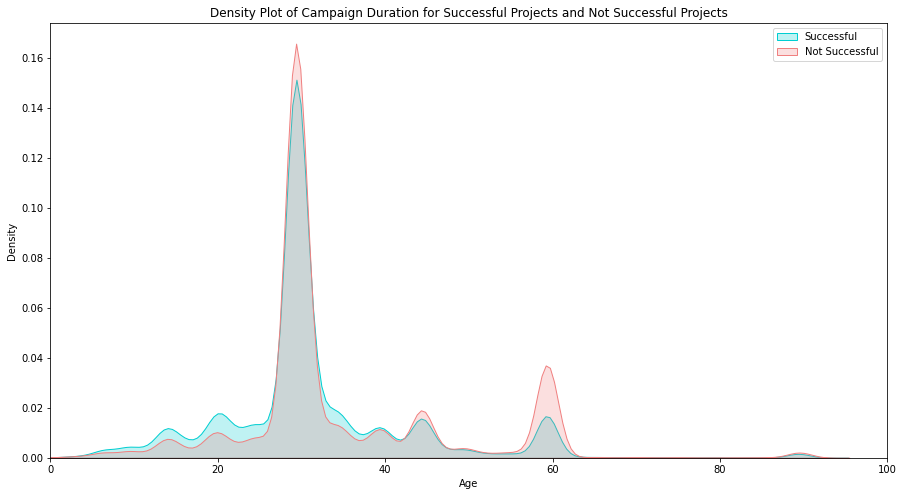

In [90]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(data['duration'][data.state == "successful"], color="darkturquoise", shade=True)
sns.kdeplot(data['duration'][data.state == "failed"], color="lightcoral", shade=True)
plt.legend(['Successful', 'Not Successful'])
plt.title('Density Plot of Campaign Duration for Successful Projects and Not Successful Projects')
ax.set(xlabel='Age')

# maximum project duration is 92 days
plt.xlim(0,100)
plt.show()


In [50]:
# find correlations
data.corr().abs()[['state']]

KeyError: "None of [Index(['state'], dtype='object')] are in the [columns]"

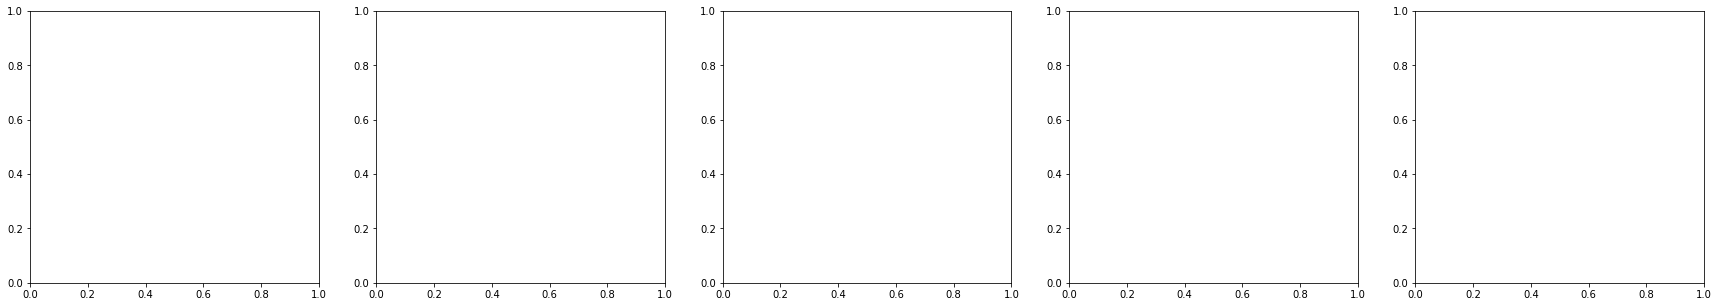

In [64]:
# make 5 subplots
fig, axs = plt.subplots(ncols=5, figsize=(30,5))

# draw plots
# sb.violinplot(x="survived", y="age", hue="sex", data=data, ax=axs[0])
# sb.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[1])
# sb.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[2])
# sb.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[3])
# sb.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[4])


In [29]:
# convert variables to be numeric
data.replace({'male': 1, 'female': 0}, inplace=True)

# find correlation
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265


In [30]:
# create new relatives column, if sibling, spouce or parent, then relative
data['relatives'] = data.apply (lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265
relatives,0.201719


In [31]:
#keep all parameters with high correlation, drop rest
data = data[['sex', 'pclass','age','relatives','fare','survived']].dropna()